In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from tensorflow.keras.backend import constant
from tensorflow.keras import optimizers

#from keras.engine.topology import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from scipy.stats import random_correlation
from sklearn.datasets import make_sparse_spd_matrix

In [1]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

#from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt
from scipy.stats import random_correlation
from sklearn.datasets import make_sparse_spd_matrix

Using TensorFlow backend.


In [2]:
## Generalisation to multiple stocks -- SET D= # of stocks
N=30 # time disrectization
m = 2#number of stocks
S0 = np.random.normal(1,0.0,m).reshape(1,m) # initial value of the asset(s)
X0=1  # initial wealth
T=1 # maturity
sigma=0.2 # volatility in Black Scholes
gamma=0.0
sigma = np.abs(np.random.normal(0.2,gamma,m).reshape(m,))
mu=np.random.normal(0.1,0.2,m).reshape(1,m)
#mu = np.array([0.1,0.3])
r=0.05
uncertainty = 0.5

R=10**5 # number of Trajectories
eigenvals = []
if m > 1:
    for _ in range(m):
        eigenvals.append(np.random.uniform(0,m))
    eigenvals = m/sum(eigenvals)*np.array(eigenvals)
    rho = random_correlation.rvs(eigenvals)

#Turn elements ON/OFF
VAR_RATE = False
INSIDER = False
VASICEK = True

#Vasicek interest rate
a = 0.5
b = 0.02
r_sigma = 0.02

In [ ]:
# logS= np.zeros((N,R))
# logS[0,]=np.log(S0)*np.ones((1,R))

# for i in range(R):
#     for j in range(N-1):
#         increment = np.random.normal(mu*T/N-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
#         logS[j+1,i] =logS[j,i]+increment

# S=np.exp(logS)

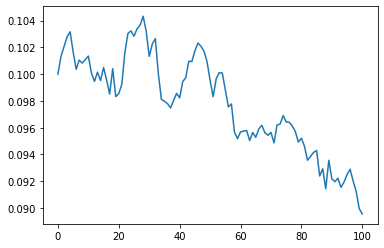

In [23]:
r = 0.1
a = 0.5
b = 0.05
r_sigma = 0.01
N=100
dt = T/N
rs=[r]

for i in range(N):
    rs.append(rs[i]+a*(b-rs[i])*dt+r_sigma*np.random.normal(0,np.sqrt(T)/np.sqrt(N)))
plt.plot(range(N+1),rs)
plt.show()

In [3]:
#Definition of neural networks for trading strategies

#m = D # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0.5),
                          name=str(i)+str(j))
        layers = layers + [layer]

In [9]:
# Implementing the outcoming of trading via neural networks
# Inputs is the training set below, containing the price S0, 
# again we record the trading strategies on separate input variables 'tradeeval' to read them out easily later
price = Input(shape=(m,))
trade = Input(shape=(m,))
tradeeval = Input(shape=(m,))
wealth = Input(shape=(1,))
inputs = [price]+[trade]+[tradeeval]+[wealth]

if VASICEK: 
    r_0 = Input(shape=(1,))
    inputs += [r_0]

outputhelper=[]
r_t = r_0
for j in range(N):
    #strategy = price
    #strategyeval=tradeeval
    
    
    incr = Input(shape=(m,))
    if INSIDER: #giving the model insider information on the movement of the stocks at next timestep
        flip = Input(shape=(m,))
        insider = Lambda(lambda x: tf.math.sign(x))(incr)
        insider = Multiply()([flip,insider]) #flip the information with proba = uncertainty
        strategy = Lambda(lambda x: tf.concat(x,axis=1))([price,insider])
        strategyeval = Lambda(lambda x: tf.concat(x,axis=1))([tradeeval,insider])   
    else:
        strategy = Lambda(lambda x: tf.concat(x,axis=1))(price)
        strategyeval = Lambda(lambda x: tf.concat(x,axis=1))(tradeeval)  
    
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the alpha at j 
        strategyeval=layers[k+(j)*d](strategyeval)
        
    #implement strategy dependent interest
    if not VASICEK:
        helper0a = Lambda(lambda x : K.sum(x,axis=1,keepdims=True))(strategy) #sum over all alphas
        helper0b = Lambda(lambda x: K.less(1.0,x))(helper0a) #check if the sum of alphas is larger than 1
        helper0b = Lambda(lambda x: tf.cast(x,tf.float32))(helper0b)
        r_t = Lambda(lambda x: (mu.mean()-r)*(helper0a-1)*x+r)(helper0b) #adapt interest rate
        if not VAR_RATE: r_t = Lambda(lambda x: 0*x+r)(r_t)
    else:  #Vasicek model
        r_incr = Input(shape=(1,))
        vasi_helper = Lambda(lambda x: a*(b-x)*T/N)(r_t)
        r_t = Add()([r_t,vasi_helper,r_incr])
      
    #incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)
    price=pricenew
    logwealth= Lambda(lambda x : K.log(x))(wealth)    
   
    #logwealth= Lambda(lambda x : x+r*T/N)(logwealth) # <---- r value
    helperR = Lambda(lambda x : x*T/N)(r_t)
    logwealth = Add()([helperR,logwealth])
  
    helper1 = Multiply()([strategy, incr])
    helper1 = Lambda(lambda x : K.sum(x,axis=1))(helper1)
    logwealth = Add()([logwealth, helper1])
    if m == 1:
        helper2 = Multiply()([strategy, strategy])   
        #helper2 = Lambda(lambda x : K.sum(x,axis=1))(helper2)
        helper3 = Lambda(lambda x : x*sigma**2/2*T/N)(helper2)
        helper3 = Lambda(lambda x: K.sum(x,axis=1))(helper3)
        logwealth = Subtract()([logwealth, helper3])
       
    helper4 = Lambda(lambda x: K.sum(x,axis=1))(strategy)
    #helper4 = Lambda(lambda x : x*r*T/N)(helper4) # <----- r value
    helper4 = Multiply()([helper4,helperR])
    
    logwealth = Subtract()([logwealth, helper4])
       

    sigma_strat = Lambda(lambda x: sigma*x)(strategy) #Multiply the alphas by the sigmas
    rho_temp =K.constant(rho,dtype='float32') #Cast correlation matrix into layer
    #helper5 = Lambda(lambda x: tf.einsum('ki,ij,jk->k',x[0],x[1],x[2]))([sigma_strat,rho_temp,K.transpose(sigma_strat)])
    if m>1 :
        helper5 = Lambda(lambda x: K.dot(x,rho_temp))(sigma_strat)
        helper5 = Lambda(lambda x: K.dot(x,K.transpose(sigma_strat)))(helper5) #Compute the matrix term
        helper5 = Lambda(lambda x: tf.linalg.diag_part(x))(helper5)
        helper5 = Lambda(lambda x : 0.5*x*T/N)(helper5)

        logwealth = Subtract()([logwealth, helper5])
        
    
    wealthnew=Lambda(lambda x : K.exp(x))(logwealth)# creating the wealth at time j+1
    
    inputs = inputs + [incr]
    if VASICEK : inputs +=[r_incr]
    if INSIDER: inputs +=  [flip]
    
       
    outputhelper = outputhelper + [r_t] +[strategyeval] # here we collect the strategies    
    wealth=wealthnew
    #print(K.int_shape(logwealth))
outputs = wealth

outputs = [outputs] + outputhelper

outputs = Concatenate()(outputs)

model_MertonD = Model(inputs=inputs, outputs=outputs)

In [10]:
Ktrain = 10**5
initialprice = S0
initialwealth = X0

#Generate correlated price processes

from scipy.linalg import cholesky

uncorr = [np.random.normal(0,np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)] #generate uncorrelated price processes

if m >1:
    corr = []
    corr_inside = []
    U= cholesky(rho)
    #U = np.array([[1,-1],[0,0]])
    for unc in uncorr:
        corr.append(unc@U*sigma+mu*T/N)#Correlate the processes with the Cholesky decomposition of rho
        if VASICEK: corr.append(r_sigma*np.random.normal(0,np.sqrt(T)/np.sqrt(N),(Ktrain,1)))
        if INSIDER: corr.append(np.random.choice([-1,1],size=(Ktrain,m),p=[uncertainty,1-uncertainty]))
        
else:
    corr = [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)]
# xtrain consists of the price S0, 
#the initial hedging being 0, and dummy variables hedgeeval where the strategies are evaluated, 
#the initial wealth and the increments of the log price process     

if VASICEK:
    xtrain = ([np.ones((Ktrain,1))@initialprice] +
              [np.zeros((Ktrain,m))]+
              [1*np.ones((Ktrain,m))] +
              [initialwealth*np.ones((Ktrain,1))] +
              [r*np.ones((Ktrain,1))]
              + corr)
else:
    xtrain = ([np.ones((Ktrain,1))@initialprice] +
              [np.zeros((Ktrain,m))]+
              [1*np.ones((Ktrain,m))] +
              [initialwealth*np.ones((Ktrain,1))] + corr)

ytrain=np.zeros((Ktrain,1+N))

In [56]:
#Mean-Variance optimisation

cov = np.diag(sigma)@rho@np.diag(sigma)
r_vec = r*np.ones(m)

# p = 0.051 #Required return - risk factor
# premium = (mu-r_vec).reshape(m,)
# lambd = (p-r)/np.einsum('i,ij,j',premium,cov,premium)
# w_opt = np.array(lambd*np.matrix(cov)**(-1)@premium)

q=0.7
w_opt = np.array(np.matrix(cov)**(-1)@(q*mu-r_vec).reshape(m,))

print(w_opt)

#Compute final wealth:
wealth = initialwealth*np.ones((Ktrain,1))
s_t = np.ones((Ktrain,1))@initialprice
logS = np.log(s_t)
logX = np.log(np.ones([Ktrain,1]))
for incr in corr:
    logS += incr
    logX += incr@w_opt.T + (1-w_opt.sum())*r*T/N - 0.5*w_opt@cov@w_opt.T*T/N
#print(np.exp(logX))
print(np.exp(logX).mean())
print(np.exp(logX).std())

In [6]:
def custom_loss(y_true,y_pred):
    z = - K.log(y_pred[:,0])#-((y_pred[:,0]**gamma-1)/gamma
    z=K.mean(z)
    return z
#def custom_loss(y_true,y_pred):
#    z = K.exp(- y_pred[:,0]*ra)#
#    z=K.mean(z)
#    return z

In [11]:
from tensorflow.keras import optimizers

adam=optimizers.Adam(lr=0.01)

model_MertonD.compile(optimizer='adam',loss=custom_loss)#,experimental_run_tf_function=False)

In [12]:
for i in range(1):
    model_MertonD.fit(x=xtrain,y=ytrain, epochs=1,verbose=True,batch_size=100)

Epoch 1/1
100000/100000 [==============================] - 33s 333us/step - loss: -0.2339


In [13]:
y_pred = model_MertonD.predict(xtrain)
print(np.mean(-np.log(y_pred[:,0])))

-0.24218534


In [20]:
for i in range(m+2):
    print(y_pred[:,i])

[0.9789995  0.52521586 0.7757853  ... 3.8276336  5.426083   1.9134591 ]
[0.04885995 0.05178663 0.04747962 ... 0.04116333 0.04886698 0.04162113]
[0.2053518  0.2053518  0.2053518  ... 0.2053518  0.20535126 0.20535126]
[-2.6963046 -2.6963046 -2.6963046 ... -2.6963046 -2.6963043 -2.6963043]


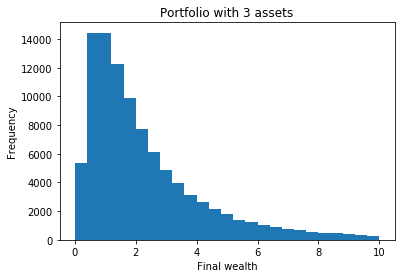

Mean wealth for portfolio with 3 assets: 2.6125715
STD of wealth for portfolio with 3 assets: 2.959329


In [48]:
import matplotlib.pyplot as plt
plt.hist(y_pred[:,0],bins = 25,range=(0,10))
plt.xlabel('Final wealth')
plt.ylabel('Frequency')
plt.title('Portfolio with ' +str(m) + ' assets')
plt.show()
print('Mean wealth for portfolio with',m,'assets:',np.mean(y_pred[:,0]))
print('STD of wealth for portfolio with',m,'assets:',np.std(y_pred[:,0]))

In [ ]:
for i in range(1):
    plt.plot(S[:,i])
plt.show()

In [ ]:
plt.hist(X[N-1,:])
plt.show()
print(np.mean(X[N-1,:]))
print(np.std(X[N-1,:]))

In [ ]:
#k=10#Choose a number between 1 and N-1
Ktest=60
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [np.linspace(0.7,1.5,Ktest)] +#change this if you go to higher dimensions
          [initialwealth*np.ones((Ktest,m))]+
          [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])


#Comparison of learned and true alpha
s=np.linspace(0.7,1.5,Ktest)

for k in range(1,N):
    truestrat=(mu-r)/(sigma**2*(1-gamma))*np.ones(Ktest)
    learnedstrat=model_Merton.predict(xtest)[:,k]
    plt.plot(s,learnedstrat,s,truestrat)
plt.show()
print((mu-r)/(sigma**2*(1-gamma)))